### Wellcome to EDA work

El proposito de este notebook es el de explorar los datos a traves de la agregacion de estos.

Datasets:
- review-001.json: Reseñas de usuarios.
- user-002.parquet: 
- business.pickle
- Python_gmaps_metada
- Python_Datasets_gmpas_reviews

Los retos son:

* Archivos muy pesados.
* Diferentes formatos en los datasets.
* Tal vez algo de limpieza y transformacion.


Herramientas ocupadas

* Polars - Lazy Frames (under SQL context)
* Pandas - Data Frames
* PySpark - Tables (Also under SQL context)

In [1]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

### Google Reviews

Este dataset es parquet contiene casi 90 millones de registros. Estos son solo las reseñas de los usuarios donde este se relaciona con el dataset de metadata. En metadata se elabora mas columnas que serivran para poder filtrar nuestra data y asi dar breves reportes.

Debido a que es un dara set muy pesado, esto solo es posible con pyarrow. Es una libreria cuya 

In [2]:
directorio_google_reviews = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\google_maps\\Python_Datasets_gmpas_reviews.parquet"

google_reviews = pq.read_table(directorio_google_reviews)

Hasta este paso, el dataset cargado a googlereviews es relativamente ligero, al menos en la PC consume poco arriba de 3.5 GB.. al pasarlo a pandas es cuando hay un consumo significante quedando la variable incluso en 34 GB.. no se si esto queda almacenado en la RAM, pero se convierte en un dataset muy pesado. Despues de tener el pandas, asignar `None` a la variable `google_reviews` para liberar un poco.

![imagen](C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\imagenes\\sprint_1\\eda_etl\\consumo_pandas.JPG)

In [3]:
google_reviews_df = google_reviews.to_pandas()
google_reviews_df.shape

(89946359, 8)

In [4]:
google_reviews_df.dtypes

user_id    float64
name        object
time         int64
rating       int64
text        object
pics        object
resp        object
gmap_id     object
dtype: object

Libera espacio en la variable `google_reviews`

In [5]:
google_reviews = None

Para hacer operaciones mas rapido en el dataframe de pandas es recomendable usar el backend de pyarrow para el tipo de dato haciendo lo siguiente (puede demorar algunos minutos)

In [6]:
google_reviews_df = google_reviews_df.convert_dtypes(dtype_backend="pyarrow")
google_reviews_df.dtypes

c:\Users\jdieg\Desktop\henry\proyectos\Google-Yelp\.proyecto_final_env\lib\site-packages\pandas\core\dtypes\cast.py:1056: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\jdieg\Desktop\henry\proyectos\Google-Yelp\.proyecto_final_env\lib\site-packages\pandas\core\dtypes\cast.py:1080: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


user_id    double[pyarrow]
name       string[pyarrow]
time        int64[pyarrow]
rating      int64[pyarrow]
text       string[pyarrow]
pics                object
resp                object
gmap_id    string[pyarrow]
dtype: object

Y se puede intentar hacer una conversion por ejemplo de las fechas unix (columna time) a fechas normales

In [7]:
google_reviews_df.head()

,user_id,name,time,rating,text,pics,resp,gmap_id
0,1.140438e+20,Kanisha Mixon,1597168272670,5,Very Personable staff! Beautiful and clean env...,None,None,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
1,1.160090e+20,Brandie Hodges,1609899039594,5,Best clothing intown,None,None,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
2,1.062399e+20,Sharon King,1547235290843,4,<NA>,None,None,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
3,1.049701e+20,Veronica Pierce,1517709403534,5,<NA>,None,None,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
4,1.105875e+20,Whitney Waldon Collier,1535245718492,5,<NA>,None,None,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf


In [8]:
google_reviews_df["time"] = pd.to_datetime(google_reviews_df["time"], unit="ms")

In [9]:
google_reviews_df["time"]

0          2020-08-11 17:51:12.670
1          2021-01-06 02:10:39.594
2          2019-01-11 19:34:50.843
3          2018-02-04 01:56:43.534
4          2018-08-26 01:08:38.492
                     ...          
89946354   2021-03-03 03:15:23.428
89946355   2019-06-30 21:58:31.835
89946356   2017-07-26 00:36:06.785
89946357   2019-08-10 19:54:20.108
89946358   2020-04-19 13:20:38.249
Name: time, Length: 89946359, dtype: datetime64[ns]

Y solo demoro 9.8 segundos convertir 89,946,359 registros. Esto convence que pyarrow sera una buena herramienta para la exploratoria de datos. Invito ampliamente a conocer a fondo las bondades de esta API de python que se esta empleando [pyarrow](https://arrow.apache.org/docs/python/index.html).

NO OLVIDES CONVERTIR NUEVAS COLUMNAS A pyarrow BACKEND!

aunque esto es solo para numericos (enteros y decimales, conocidos en arrow int y double respectivamente) y cadena de caracteres (texto)

In [10]:
google_reviews_df["time"].convert_dtypes(dtype_backend="pyarrow")
google_reviews_df.dtypes

user_id    double[pyarrow]
name       string[pyarrow]
time        datetime64[ns]
rating      int64[pyarrow]
text       string[pyarrow]
pics                object
resp                object
gmap_id    string[pyarrow]
dtype: object

### Nulos

En porcentaje en cada columna

In [11]:
def proporcion_nulos(data_frame:pd.DataFrame):
    """
    Calculate the percentage of null (missing) values in each column of a Pandas DataFrame.

    Parameters:
    data_frame (pd.DataFrame): The input DataFrame for which null percentages are calculated.

    Returns:
    pd.Series: A Pandas Series containing the percentage of null values for each column.
    """
    return data_frame.isnull().sum() / data_frame.shape[0] * 100

In [12]:
proporcion_nulos(google_reviews_df)

user_id     0.000000
name        0.000000
time        0.000000
rating      0.000000
text       43.701318
pics       97.225370
resp       87.738125
gmap_id     0.000000
dtype: float64

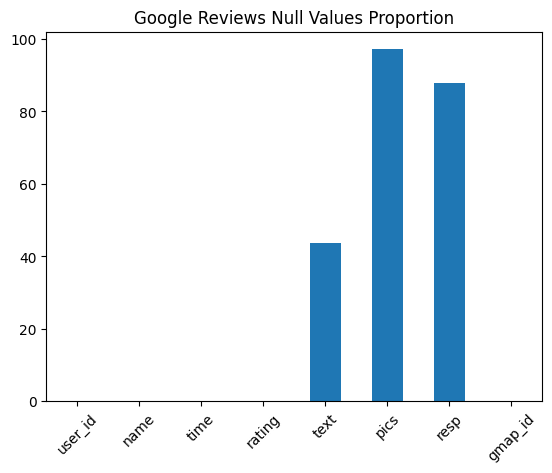

In [13]:
proporcion_nulos(google_reviews_df).plot(kind="bar", rot=45, title="Google Reviews Null Values Proportion");

Ciertamente hay columnas con un considerable porcentaje de valores nulos.

In [15]:
google_reviews_df.drop(["pics", "resp"], axis=1, inplace=True)

In [17]:
google_reviews_df.head()

,user_id,name,time,rating,text,gmap_id
0,1.140438e+20,Kanisha Mixon,2020-08-11 17:51:12.670,5,Very Personable staff! Beautiful and clean env...,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
1,1.160090e+20,Brandie Hodges,2021-01-06 02:10:39.594,5,Best clothing intown,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
2,1.062399e+20,Sharon King,2019-01-11 19:34:50.843,4,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
3,1.049701e+20,Veronica Pierce,2018-02-04 01:56:43.534,5,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf
4,1.105875e+20,Whitney Waldon Collier,2018-08-26 01:08:38.492,5,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf


In [19]:
google_reviews_df["time"].min(), google_reviews_df["time"].max()

(Timestamp('1990-12-31 00:00:00'), Timestamp('2021-09-09 16:22:53.205000'))

In [21]:
google_reviews_df["year"] = google_reviews_df["time"].dt.year

In [22]:
google_reviews_df["year"] = google_reviews_df["year"].convert_dtypes(dtype_backend="pyarrow")

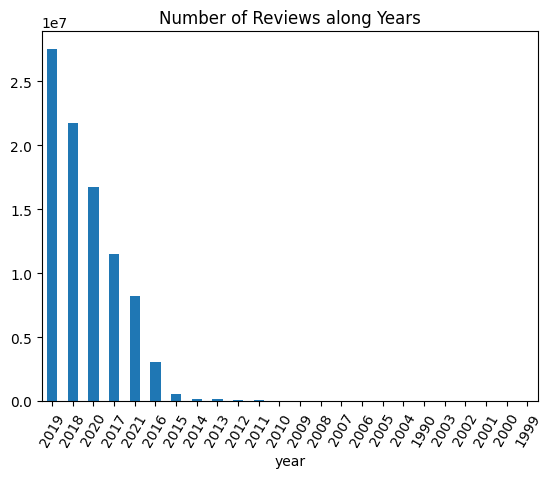

In [23]:
google_reviews_df["year"].value_counts().plot(kind="bar", rot=60, title="Number of Reviews along Years");

In [25]:
(google_reviews_df["year"] > 2011).sum()

89851857

In [27]:
google_reviews_df.shape[0] - (google_reviews_df["year"] > 2011).sum()

94502

In [46]:
chunk_size = 9000000

chunks = [google_reviews_df[idx_pos: idx_pos + chunk_size] for idx_pos in range(0, len(google_reviews_df), chunk_size)]

result_df = pd.DataFrame()

for chunk in chunks:
    chunk = chunk[chunk["year"] > 2011]
    result_df = pd.concat([result_df, chunk], ignore_index=True)

In [48]:
google_reviews_df = result_df

In [52]:
proporcion_nulos(google_reviews_df)

user_id     0.000000
name        0.000000
time        0.000000
rating      0.000000
text       43.695738
gmap_id     0.000000
year        0.000000
dtype: float64

In [58]:
google_reviews_df

,user_id,name,time,rating,text,gmap_id,year
0,1.140438e+20,Kanisha Mixon,2020-08-11 17:51:12.670,5,Very Personable staff! Beautiful and clean env...,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf,2020
1,1.160090e+20,Brandie Hodges,2021-01-06 02:10:39.594,5,Best clothing intown,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf,2021
2,1.062399e+20,Sharon King,2019-01-11 19:34:50.843,4,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf,2019
3,1.049701e+20,Veronica Pierce,2018-02-04 01:56:43.534,5,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf,2018
4,1.105875e+20,Whitney Waldon Collier,2018-08-26 01:08:38.492,5,<NA>,0x8862134e67ff5c87:0x38b5e2ae99cd1fcf,2018
...,...,...,...,...,...,...,...
89851852,1.078991e+20,Carlene Calabaza,2021-03-03 03:15:23.428,5,<NA>,0x53349429523d615b:0x2a66a9272032e8b4,2021
89851853,1.173878e+20,Gizmo,2019-06-30 21:58:31.835,5,<NA>,0x53349429523d615b:0x2a66a9272032e8b4,2019
89851854,1.078871e+20,Jan Soucek,2017-07-26 00:36:06.785,5,<NA>,0x53349429523d615b:0x2a66a9272032e8b4,2017
89851855,1.047652e+20,Kyle Leatherow,2019-08-10 19:54:20.108,3,<NA>,0x53349429523d615b:0x2a66a9272032e8b4,2019


### I quick view on the count of ratings

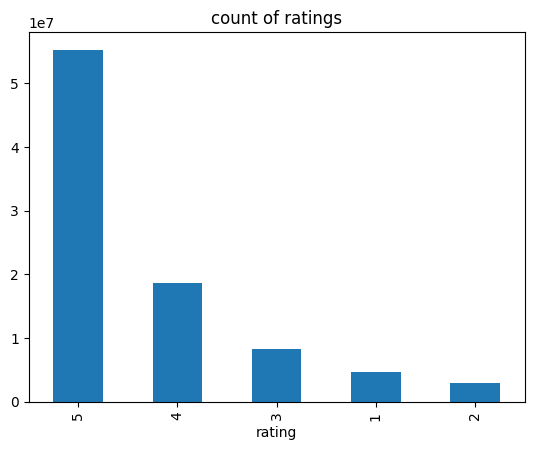

In [62]:
google_reviews_df["rating"].value_counts().plot(kind="bar", rot=90, title="count of ratings");

### Metadata

A comparacion de gmaps_review, este parquet es relativamente mas ligero, siendo pandas capaz de la lectura de el archivo parquet

In [128]:
directorio_metadata_reviews =  "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\google_maps\\Python_gmaps_metada.parquet"

metada_reviews_df = pd.read_parquet(directorio_metadata_reviews).convert_dtypes(dtype_backend="pyarrow")
metada_reviews_df.dtypes

name                string[pyarrow]
address             string[pyarrow]
gmap_id             string[pyarrow]
description         string[pyarrow]
latitude            double[pyarrow]
longitude           double[pyarrow]
category                     object
avg_rating          double[pyarrow]
num_of_reviews       int64[pyarrow]
price               string[pyarrow]
hours                        object
MISC                         object
state               string[pyarrow]
relative_results             object
url                 string[pyarrow]
dtype: object

In [ ]:
metada_reviews_df.shape

(<Axes: title={'center': 'Null Proportion ofor Metadata'}>,
 name                 0.001223
 address              2.661511
 gmap_id              0.000000
 description         91.593783
 latitude             0.000000
 longitude            0.000000
 category             0.575833
 avg_rating           0.000000
 num_of_reviews       0.000000
 price               90.902413
 hours               26.029823
 MISC                22.837405
 state               24.676109
 relative_results     9.753948
 url                  0.000000
 dtype: float64)

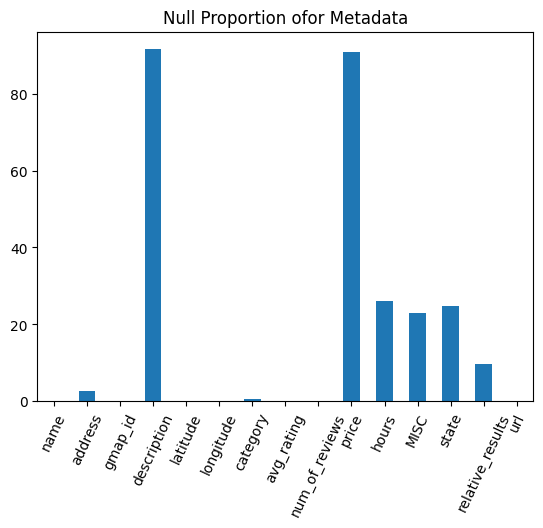

In [129]:
proporcion_nulos(metada_reviews_df).plot(kind="bar", rot=65, title="Null Proportion ofor Metadata"),proporcion_nulos(metada_reviews_df)

In [130]:
metada_reviews_df.drop(["description", "price"], axis=1, inplace=True)

### Getting States

In [131]:
proporcion_nulos(metada_reviews_df)

name                 0.001223
address              2.661511
gmap_id              0.000000
latitude             0.000000
longitude            0.000000
category             0.575833
avg_rating           0.000000
num_of_reviews       0.000000
hours               26.029823
MISC                22.837405
state               24.676109
relative_results     9.753948
url                  0.000000
dtype: float64

First, let's get rid off null on address rows

In [132]:
metada_reviews_df = metada_reviews_df[~metada_reviews_df["address"].isna()]

Then, builgind up our lambdas expresion on small porcion for testing

In [133]:
small_metadata = metada_reviews_df[:200]

In [134]:
(
    small_metadata["address"]
    # Get address element
    .apply(lambda row: [address_element.strip() for address_element in row.split(",")][-1])
    # Get the element of City
    .apply(lambda x: x.split()[0])

    )

0      GA
1      CA
2      CA
3      CA
4      CA
       ..
205    FL
206    CA
207    ID
208    TX
210    TX
Name: address, Length: 200, dtype: object

In [135]:
metada_reviews_df["us_state"] = (
    metada_reviews_df["address"]
    # Get address element
    .apply(lambda row: [address_element.strip() for address_element in row.split(",")][-1])
    # Get the element of City
    .apply(lambda x: x.split()[0])

    )

In [137]:
metada_reviews_df["us_state"]

0          GA
1          CA
2          CA
3          CA
4          CA
           ..
3025006    IL
3025007    CA
3025008    WY
3025009    AZ
3025010    WY
Name: us_state, Length: 2944500, dtype: object

In [115]:
usps_state_abbreviations = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}


In [122]:
(state_code for state_code in usps_state_abbreviations.keys())

<generator object <genexpr> at 0x000001EDC7580900>

In [139]:
us_states_set = set(list(usps_state_abbreviations.keys()))

In [148]:
metada_reviews_df = metada_reviews_df[metada_reviews_df["us_state"].apply(lambda state: state in us_states_set)]

In [151]:
metada_reviews_df.shape

(2875143, 14)

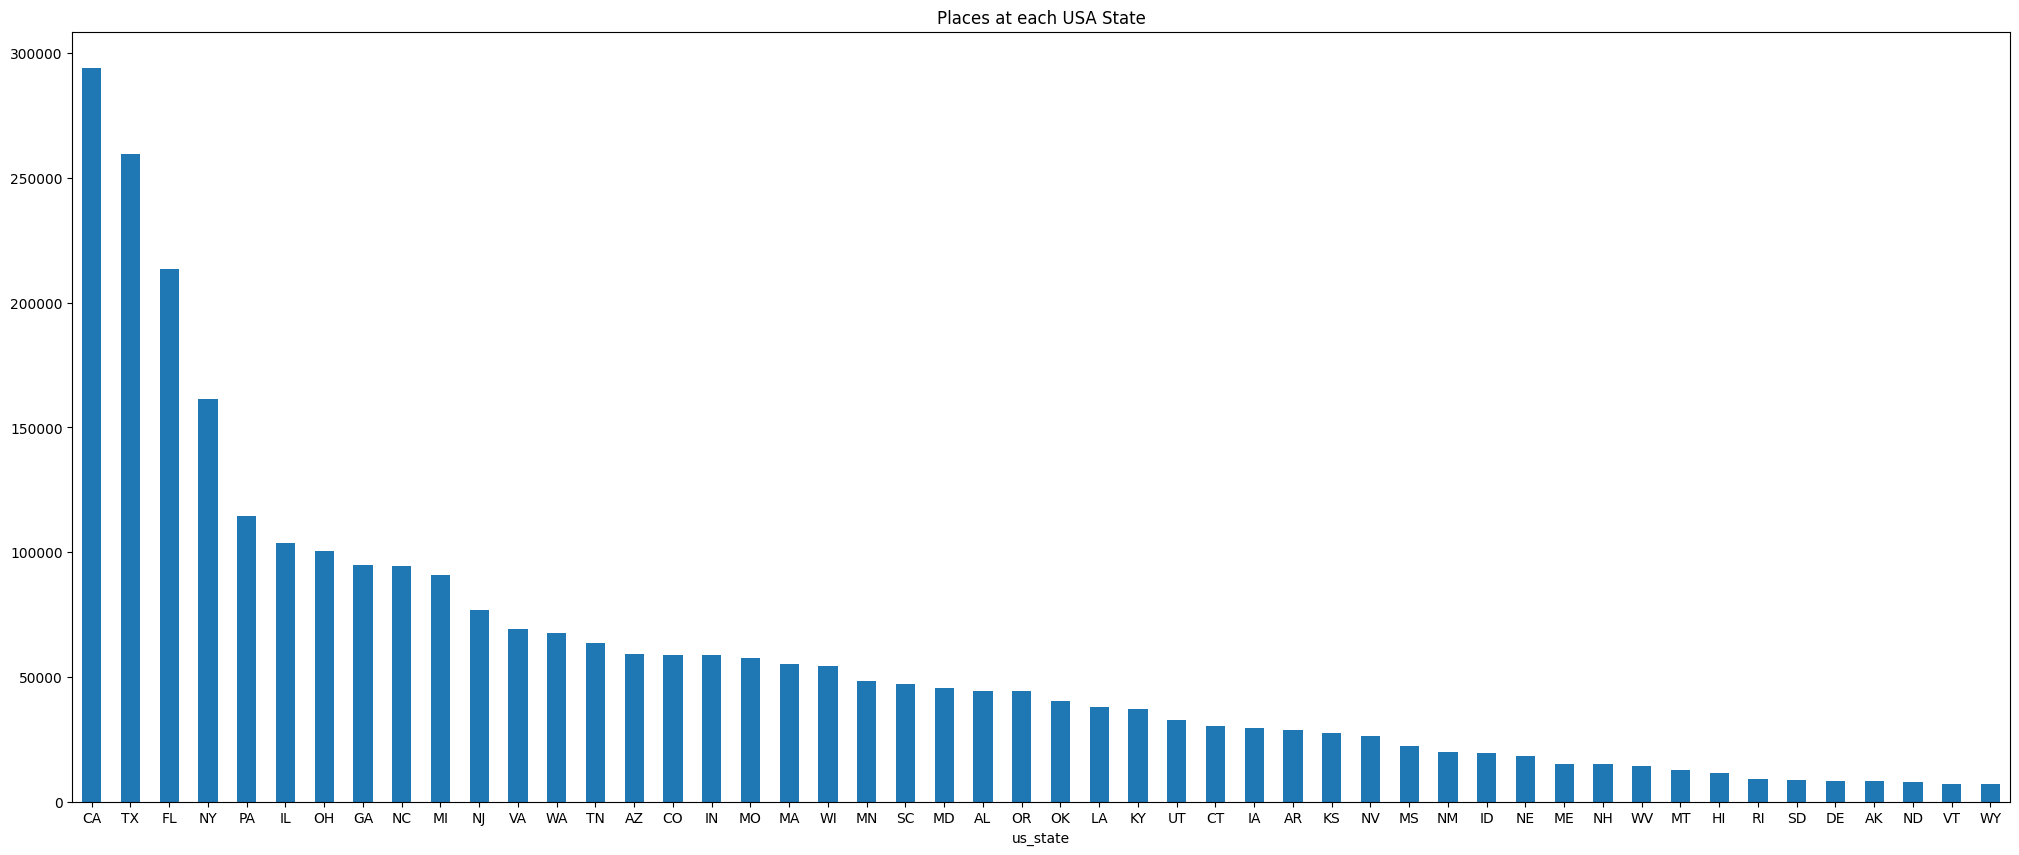

In [159]:
metada_reviews_df["us_state"].value_counts().plot(kind="bar", figsize=(25, 10), rot=0, title="Places at each USA State");

In [160]:
usps_state_abbreviations["MS"]

'Mississippi'

### Categories

Getting rid off nulls

In [190]:
proporcion_nulos(metada_reviews_df)

name                 0.000000
address              0.000000
gmap_id              0.000000
latitude             0.000000
longitude            0.000000
category             0.591449
avg_rating           0.000000
num_of_reviews       0.000000
hours               25.886086
MISC                20.858232
state               24.486469
relative_results     8.697411
url                  0.000000
us_state             0.000000
dtype: float64

Number of nulls

In [195]:
metada_reviews_df["category"].isnull().sum()

17005

In [196]:
metada_reviews_df.dropna(subset="category", axis=0, inplace=True)

C:\Users\jdieg\AppData\Local\Temp\ipykernel_11168\2732016685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metada_reviews_df.dropna(subset="category", axis=0, inplace=True)


In [184]:
([category in set(["Restaurant", "Bar"])for category in ["Bar", "Campground"]].count(True) > 0)

True

In [279]:
set_categories = {"restaurant", "bar", "bakery", "seafood", "restaurant", "cafe",
                  "ice creame shop", "chinese restaurant", "italiant restaurant", 
                   "japanese restaurant", "bistro", "mexican restaurant", "grill",
                   "greek restaurant", "thai restaurant", "indian restaurant", "spain rastaurant",
                   "british restaurant", "tex-mex restaurant", "american restaurant",
                   "health food restaurant", "relivery restaurant", "brunch restaurant",
                   "sandwich shop", "fast food restaurant", "cake shop", "chicken restaurant",
                   "donut shop", "Coffee shop", "southern restaurant (US)", "juice shop", "Breakfast restaurant",
                   "pizza restaurant", "Bar & grill, Burrito restaurant", "pizza", "diner", "take out restaurant",
                   "Sushi restaurant", "hamburger restaurant", "Steak house", "Asian restaurant", "New American restaurant, Restaurant"}

mask_categories = metada_reviews_df["category"].apply(lambda categories: [category.lower().strip() in set_categories for category in categories].count(True) > 0)

In [283]:
metada_reviews_df = metada_reviews_df[mask_categories]

In [293]:
pd.Series(metada_reviews_df.explode(column="category")["category"].unique())

0                    Restaurant
1                        Bakery
2        Health food restaurant
3                         Diner
4                           Bar
                 ...           
1734    Bedroom furniture store
1735                    Frituur
1736        Machine maintenance
1737                     Bridge
1738         University library
Length: 1739, dtype: object

In [83]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [84]:
geolocator = Nominatim(user_agent="reverse_geocoding_example")


In [113]:
# Define a function for reverse geocoding
def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        if location is not None:
            address = location.address
            return address
        else:
            return "Location not found"
    except GeocoderTimedOut:
        return reverse_geocode(lat, lon)
    except IndexError:
        return "Unknown State"



In [120]:
reverse_geocode(34.018891, -118.21529)

'3015, East Pico Boulevard, Los Angeles, Los Angeles County, California, 90023, United States'

In [121]:
metada_reviews_df.apply(lambda row: reverse_geocode(row['latitude'], row['longitude']), axis=1)


GeocoderServiceError: [WinError 10053] Se ha anulado una conexión establecida por el software en su equipo host

### Chunkenizer

In [104]:
###################################### Snipped Code ###########################################
# # Define chunk size
# chunk_size = 10000

# # Split DataFrames into chunks
# left_chunks = [left_df[i:i+chunk_size] for i in range(0, len(left_df), chunk_size)]
# right_chunks = [right_df[i:i+chunk_size] for i in range(0, len(right_df), chunk_size)]

# # Initialize an empty result DataFrame
# result_df = pd.DataFrame()

# # Iterate through chunks and merge
# for left_chunk, right_chunk in zip(left_chunks, right_chunks):
#     merged_chunk = pd.merge(left_chunk, right_chunk, on='key', how='inner')
#     result_df = pd.concat([result_df, merged_chunk], ignore_index=True)

# # result_df contains the merged result

In [107]:
# Define chunk size
chunk_size = 100000

# Split DataFrames into chunks
chunks = [metada_reviews_df[i:i+chunk_size] for i in range(0, len(metada_reviews_df), chunk_size)]


# Initialize an empty result DataFrame
result_df = pd.DataFrame()

# Iterate through chunks and merge
for chunk in chunks:
    chunk = chunk.apply(lambda row: reverse_geocode(row['latitude'], row['longitude']).split(",")[2].strip(), axis=1)
    result_df = pd.concat([result_df, chunk], ignore_index=True)

AttributeError: 'NoneType' object has no attribute 'address'

### Dask Usage

In [1]:
import dask.array as da

images = da.ones((10000, 1000, 1000))
images

dask.array<ones_like, shape=(10000, 1000, 1000), dtype=float64, chunksize=(255, 255, 255), chunktype=numpy.ndarray>

In [1]:
import dask.dataframe as dd
from dask.distributed import Client

In [2]:
client = Client(name="google_data")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52359,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.87 GiB
Comm: tcp://127.0.0.1:52378,Total threads: 2
Dashboard: http://127.0.0.1:52379/status,Memory: 7.97 GiB
Nanny: tcp://127.0.0.1:52362,


In [3]:
directorio_google_reviews = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\google_maps\\Python_Datasets_gmpas_reviews.parquet"

google_reviews_ddf = dd.read_parquet(directorio_google_reviews)

In [4]:
google_reviews_ddf.shape

(Delayed('int-a5d4a44b-4ddf-4a50-9fc7-2694748d2f21'), 8)

In [5]:
google_reviews_ddf = google_reviews_ddf.repartition(npartitions=10)

In [5]:
google_reviews_ddf

,user_id,name,time,rating,text,pics,resp,gmap_id
npartitions=2,,,,,,,,
,float64,string,int64,int64,string,string,string,string
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [6]:
google_reviews_ddf.partitions[1].time

Dask Series Structure:
npartitions=1
    int64
      ...
Name: time, dtype: int64
Dask Name: getitem, 4 graph layers

In [7]:
google_reviews_ddf.time

Dask Series Structure:
npartitions=2
    int64
      ...
      ...
Name: time, dtype: int64
Dask Name: getitem, 3 graph layers

In [8]:
google_reviews_ddf.time = dd.to_datetime(google_reviews_ddf.time, unit="ms")

In [9]:
google_reviews_ddf.time

Dask Series Structure:
npartitions=2
    datetime64[ns]
               ...
               ...
Name: time, dtype: datetime64[ns]
Dask Name: getitem, 6 graph layers

In [10]:
earlier_date = google_reviews_ddf.time.max()

In [11]:
earlier_date.compute()

2023-09-26 20:44:01,982 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:52378 (pid=16612) exceeded 95% memory budget. Restarting...
2023-09-26 20:44:04,028 - distributed.nanny - WARNING - Restarting worker
2023-09-26 20:44:16,940 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:52381 (pid=13568) exceeded 95% memory budget. Restarting...
2023-09-26 20:44:18,509 - distributed.nanny - WARNING - Restarting worker
2023-09-26 20:44:24,229 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:52387 (pid=7676) exceeded 95% memory budget. Restarting...
2023-09-26 20:44:26,111 - distributed.nanny - WARNING - Restarting worker
2023-09-26 20:44:44,666 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:52435 (pid=1784) exceeded 95% memory budget. Restarting...
2023-09-26 20:44:46,529 - distributed.nanny - WARNING - Restarting worker
2023-09-26 20:44:49,644 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:52384 (pid=14672) exceeded 95% memor

KilledWorker: Attempted to run task ('series-max-chunk-d8c376c2cc88f84c72a8bf452eddf428-9608d496cb3095999b456762ef3f2f5d', 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:52450. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

2023-09-26 20:45:19,526 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:52443 (pid=3116) exceeded 95% memory budget. Restarting...
2023-09-26 20:45:20,268 - distributed.nanny - WARNING - Restarting worker


### Polars

In [14]:
review_lf = pl.scan_ndjson("data/yelp/review-001.json")
ctx = pl.SQLContext(register_globals=True, eager_execution=True)
df_small = ctx.execute("SELECT COUNT(date) FROM review_lf")
print(df_small)

shape: (1, 1)
┌─────────┐
│ date    │
│ ---     │
│ u32     │
╞═════════╡
│ 6990280 │
└─────────┘


In [15]:
review_lf = pl.scan_ndjson("data/yelp/review-001.json")
ctx = pl.SQLContext(lf=review_lf, eager_execution=True)
df_small = ctx.execute("""
                       SELECT *
                       FROM lf 
                       WHERE STARTS_WITH(date, '2018')
                       
                       """)
print(df_small)

shape: (906_362, 9)
┌──────────────┬──────────────┬─────────────┬───────┬───┬───────┬──────┬─────────────┬─────────────┐
│ review_id    ┆ user_id      ┆ business_id ┆ stars ┆ … ┆ funny ┆ cool ┆ text        ┆ date        │
│ ---          ┆ ---          ┆ ---         ┆ ---   ┆   ┆ ---   ┆ ---  ┆ ---         ┆ ---         │
│ str          ┆ str          ┆ str         ┆ f64   ┆   ┆ i64   ┆ i64  ┆ str         ┆ str         │
╞══════════════╪══════════════╪═════════════╪═══════╪═══╪═══════╪══════╪═════════════╪═════════════╡
│ KU_O5udG6zpx ┆ mh_-eMZ6K5RL ┆ XQfwVwDr-v0 ┆ 3.0   ┆ … ┆ 0     ┆ 0    ┆ If you      ┆ 2018-07-07  │
│ Og-VcAEodg   ┆ WhZyISBhwA   ┆ ZS3_CbbE5Xw ┆       ┆   ┆       ┆      ┆ decide to   ┆ 22:09:11    │
│              ┆              ┆             ┆       ┆   ┆       ┆      ┆ eat here,   ┆             │
│              ┆              ┆             ┆       ┆   ┆       ┆      ┆ just …      ┆             │
│ lUUhg8ltDsUZ ┆ RreNy--tOmXM ┆ cPepkJeRMtH ┆ 4.0   ┆ … ┆ 0     ┆ 1    

In [16]:
yelp_df_2018 = df_small.to_pandas()

In [17]:
yelp_df_2018["date"] = pd.to_datetime(yelp_df_2018["date"])

In [18]:
yelp_df_2018

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,lUUhg8ltDsUZ9h0xnwY4Dg,RreNy--tOmXMl1en0wiBOg,cPepkJeRMtHapc_b2Oe_dw,4.0,1,0,1,I was really between 3 and 4 stars for this on...,2018-07-17 03:30:07
2,JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5.0,0,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38
3,E9AB7V4z8xrt2uPF7T55FQ,iYY5Ii1LGpZCpXFkHlMefw,Zx7n8mdt8OzLRXVzolXNhQ,5.0,0,0,0,Amazing biscuits and (fill in the blank). Grea...,2018-04-27 23:03:21
4,A4n4YaE-owOVgTQcrVqHUw,S7bjj-L07JuRr-tpX1UZLw,I6L0Zxi5Ww0zEWSAVgngeQ,4.0,0,0,0,The cafe was extremely cute. We came at 8am an...,2018-07-07 20:50:12
...,...,...,...,...,...,...,...,...,...
906357,CphIcLTNU26TDb_YTOSgUQ,Is5IWDXWtqVMCVtedjJIQQ,VOITl4HlmC1EGJ_wVMS6_w,5.0,0,0,0,I compete in Jiu-Jitsu and every competition I...,2018-11-09 18:09:35
906358,e2owJAzHYo89x88eReSqGg,QYZM8lgZn2HL_OWYAn7E1A,nrXtCSdfWg0TJ86onEZWkg,4.0,1,0,0,Took a colleague here for dinner as we were tr...,2018-02-13 19:50:01
906359,_b_SOIkWHsNPRGW4RM3X5w,L_fdAnrH5Pxi4PqF08_ToA,ez4kMLP6OJEIaMbMrrGRdA,5.0,1,1,1,My sister and I went on the ghost tour with Th...,2018-12-10 16:31:32
906360,cACxcUY_AIsQKkpDRXuqnw,MCzlzlOw7IGbRAKVjJBPtg,fcGexL5VH5G2Xw0tRj9uOQ,3.0,1,1,0,This is a good pizza option - they deliver thr...,2018-03-13 13:54:48


### Pandas

In [19]:
yelp_user_df = pd.read_parquet("data/yelp/user-002.parquet")

In [20]:
import sys
sys.getsizeof(yelp_user_df) / 1000000

3834.143945

In [21]:
yelp_user_df.dtypes

user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

In [22]:
yelp_user_df.isnull().sum()

user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
dtype: int64

In [23]:
yelp_user_df.shape

(2105597, 22)

In [24]:
# Dangerous code! This will run something very large computationally talking 
# yelp_user_df.agg([np.mean, np.median, np.std])

In [25]:
yelp_2018 = yelp_df_2018.merge(yelp_user_df, on="user_id")

In [26]:
yelp_2018.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful_x', 'funny_x',
       'cool_x', 'text', 'date', 'name', 'review_count', 'yelping_since',
       'useful_y', 'funny_y', 'cool_y', 'elite', 'friends', 'fans',
       'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'],
      dtype='object')

In [27]:
yelp_2018[yelp_2018.duplicated(subset=["user_id"])][['review_id', 'user_id', 'business_id', 'stars', 'useful_x', 'funny_x',
       'cool_x', 'text', 'date', 'name', 'review_count', 'yelping_since',
       'useful_y', 'funny_y', 'cool_y', 'elite', 'friends', 'fans',
       'average_stars']].head()#.groupby("user_id").count().sort_values(by="review_id", ascending=False)

,review_id,user_id,business_id,stars,useful_x,funny_x,cool_x,text,date,name,review_count,yelping_since,useful_y,funny_y,cool_y,elite,friends,fans,average_stars
1,Bqn8psEmvYTO7izrnGNgqg,mh_-eMZ6K5RLWhZyISBhwA,8eDkw7CE0NKqMknPIu26fw,5.0,1,0,0,We tried this place on our first trip to New O...,2018-04-25 17:04:09,Melanie,33,2016-01-13 17:20:44,32,3,8,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0,4.06
2,78MWkzX8uQz0kDnhlhwAAg,mh_-eMZ6K5RLWhZyISBhwA,mOk3D7VczrDapNuUgLxUQw,4.0,2,0,2,So glad we stumbled upon this restaurant! It i...,2018-10-29 21:54:59,Melanie,33,2016-01-13 17:20:44,32,3,8,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0,4.06
3,krpCZHUj222Ha7AffGUZHQ,mh_-eMZ6K5RLWhZyISBhwA,L4kfcADLCU4T33i7Z0CkuA,2.0,3,0,1,I was looking forward to a romantic dinner her...,2018-02-11 03:07:30,Melanie,33,2016-01-13 17:20:44,32,3,8,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0,4.06
4,JpVqv0oZNcZyd9NqgG7tTA,mh_-eMZ6K5RLWhZyISBhwA,QWF_PoD4PthsYsq2Tk0GEQ,3.0,0,0,0,We moved to this area recently and have been l...,2018-01-21 18:08:11,Melanie,33,2016-01-13 17:20:44,32,3,8,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0,4.06
5,TbExVvMwCPOcKZwBq-uWRg,mh_-eMZ6K5RLWhZyISBhwA,v43sH62YQMO60zIiLR65DA,4.0,0,0,0,We like this place because of its convenience ...,2018-06-21 22:34:21,Melanie,33,2016-01-13 17:20:44,32,3,8,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0,4.06


In [28]:
# How many users leave a review in 2018?
len(yelp_2018["user_id"].unique())

422063

### PAndas: Exploring Business Dataset

In [29]:
business_df = pd.read_pickle("data/yelp/Yelp-20230909T191413Z-003/Yelp/business.pkl")

In [30]:
business_df[business_df.iloc[:,0] == "VOITl4HlmC1EGJ_wVMS6_w"]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
146428,VOITl4HlmC1EGJ_wVMS6_w,South Tampa Jiu-Jitsu & MMA,4477 W Gandy Blvd,Tampa,PA,33611,27.894652,-82.520573,5.0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
business_df.shape

(150346, 28)

In [33]:
business_df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'business_id', 'name', 'address',
       'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars',
       'review_count', 'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

It seems there are a few duplicated column names... Wha do they contain?

In [34]:
business_df.isna().sum()

business_id          0
name                 0
address              0
city                 0
state                3
postal_code          0
latitude             0
longitude            0
stars                0
review_count         0
is_open              0
attributes       13744
categories         103
hours            23223
business_id     150341
name            150341
address         150341
city            150341
state           150341
postal_code     150341
latitude        150341
longitude       150341
stars           150341
review_count    150341
is_open         150341
attributes      150341
categories      150341
hours           150341
dtype: int64

Certianly, null values only.. but.. that null values counting is bit smaller that the total records.. there should be data to be saved.

Indeed, 5 records that somehow the duplicated columns are not empty.. but.. hw it's happened? I do not know, I let's save this for a while since that question does not belong to the scope

In [35]:
business_df[~business_df.iloc[:,-1].isna()]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
590,6_Zf2QsRHCH1RhbzA9inyw,Starbucks,8602 Hillsborough Ave,Tampa,LA,33615,27.99637,-82.580954,3.0,56,...,LA,33615,27.99637,-82.580954,3.0,56,1,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Coffee & Tea, Food","{'Monday': '5:30-21:0', 'Tuesday': '5:30-21:0'..."
613,Iipfa9Kaac9XH5Vo8GQwvg,Starbucks,5956 153 Avenue,Edmonton,PA,T5Y 2W1,53.616147,-113.432424,3.5,10,...,PA,T5Y 2W1,53.616147,-113.432424,3.5,10,1,"{'BusinessParking': '{'garage': False, 'street...","Coffee & Tea, Food","{'Monday': '5:30-22:0', 'Tuesday': '5:30-22:0'..."
978,oY6osC4Ch3PvguA7D1hh_w,Starbucks,1251 Route 130 S,Cinnaminson,AZ,08077,40.000157,-74.987313,4.5,7,...,AZ,08077,40.000157,-74.987313,4.5,7,1,"{'WiFi': 'u'free'', 'BusinessParking': '{'gara...","Coffee & Tea, Food","{'Monday': '5:30-20:0', 'Tuesday': '5:30-20:0'..."
1296,pxuMxh5oC7W-PDN9wwvozg,Starbucks,219 N Center St,Reno,FL,89501,39.527772,-119.812518,3.0,44,...,FL,89501,39.527772,-119.812518,3.0,44,0,"{'BikeParking': 'False', 'Caters': 'False', 'O...","Coffee & Tea, Food","{'Monday': '5:30-19:0', 'Tuesday': '5:30-19:0'..."
1543,lo2VbA7Lwzu3i23pQpmzlw,Starbucks,"1125 S Black Horse Pike, Space 575",Gloucester Township,NJ,08012,39.78403,-75.05207,3.0,15,...,NJ,08012,39.78403,-75.05207,3.0,15,1,"{'BikeParking': 'True', 'RestaurantsPriceRange...","Food, Coffee & Tea","{'Monday': '0:0-0:0', 'Tuesday': '10:30-20:0',..."


but.. do these duplicated columns hold same information?

The following output indicates, they do..

In [36]:
business_df[~business_df.iloc[:,-1].isna()]["categories"] # -> It seems this rows holds same information

,categories,categories
590,"Coffee & Tea, Food","Coffee & Tea, Food"
613,"Coffee & Tea, Food","Coffee & Tea, Food"
978,"Coffee & Tea, Food","Coffee & Tea, Food"
1296,"Coffee & Tea, Food","Coffee & Tea, Food"
1543,"Food, Coffee & Tea","Food, Coffee & Tea"


So let's just drop those duplicated columns.. how? by dropping "na"s through columns whose null values are more than 150k.. but this threshold will add up the null values for the duplicated name columns.. for example.. columns "attributes" one only holds 13477 missing values, and the other one it is almost completely empty.. well, the threshold will drop both columns unfortunataly u.u I think due to column column ambiguity.. so.. getting rid off ambiguity is goint to be essential

* attributes       13744
* categories         103
* hours            23223

In [37]:
business_df["attributes"].iloc[:,0].fillna("{'Attribute': 'Unknown'}",inplace=True)
business_df["categories"].iloc[:,0].fillna("Unknown Category", inplace=True)
business_df["hours"].iloc[:,0].fillna("Unknown Hours", inplace=True)

In [38]:
business_df["attributes"].iloc[:,0].fillna("{'Attribute': 'Unknown'}", inplace=True)

In [39]:
business_df["attributes"].isna().sum()

attributes     13744
attributes    150341
dtype: int64

In [40]:
business_columns = business_df.columns[:14]
business_columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [41]:
business_df.loc[business_df["attributes"].iloc[:,0].isna(), "attributes"].iloc[:,0] = "No attributes"

In [42]:
business_df.columns = range(len(business_df.columns))

In [43]:
business_df.drop(business_df.loc[:,14:].columns, axis=1, inplace=True)

In [44]:
business_df.isna().sum()

0         0
1         0
2         0
3         0
4         3
5         0
6         0
7         0
8         0
9         0
10        0
11    13744
12      103
13    23223
dtype: int64

In [45]:
business_df.columns = business_columns[:14]

In [60]:
business_df["categories"] = (business_df["categories"].astype(str).apply(lambda x: x.split(",")).
                                apply(lambda x: [x_.strip() for x_ in x]))

In [64]:
business_restaurant_df = business_df[business_df["categories"].apply(lambda x: "Restaurants" in x)]

In [65]:
business_restaurant_df.to_parquet("data/yelp/business_restaurant.parquet")

### Saving business into parquet file after dropping duplicated columns

In [46]:
#Firt of all, let's have a loot at the output
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [47]:
# business_df.to_parquet(path="data/yelp/business.parquet")

### Getting Unique Categories from Categories Features

In [48]:
categories = business_df["categories"].astype(str).apply(lambda x: x.split(","))

In [49]:
output_category = []
for array_category in categories.tolist():
    for category in array_category:
        output_category.append(category)


In [50]:
categories = pd.DataFrame(output_category)
categories

,0
0,Doctors
1,Traditional Chinese Medicine
2,Naturopathic/Holistic
3,Acupuncture
4,Health & Medical
...,...
668690,Bikes
668691,Beauty & Spas
668692,Permanent Makeup
668693,Piercing


In [51]:
categories.value_counts().sort_values(ascending=False)

 Restaurants           36978
 Food                  20998
 Shopping              18915
Restaurants            15290
 Home Services         10563
                       ...  
 Somali                    1
 College Counseling        1
First Aid Classes          1
 Parklets                  1
 Calabrian                 1
Name: count, Length: 2455, dtype: int64

In [52]:
import ast
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return "hey"

### Visualizing Large Datasets with PySpark

In [1]:
import findspark
findspark.init("C:\spark")

In [2]:
import pyspark
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("EDA_google_yelp").getOrCreate()
spark

In [5]:
reviews_json_dir = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\yelp\\review-001.json"
review_full_DS = spark.read.json(reviews_json_dir)

In [6]:
review_full_DS.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [7]:
review_full_DS.createOrReplaceTempView("reviews")

In [8]:
spark.catalog.listTables()

[Table(name='reviews', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [9]:
query_0 = """
SELECT MIN(date), MAX(date)
FROM reviews
"""
spark.sql(query_0).show()

+-------------------+-------------------+
|          min(date)|          max(date)|
+-------------------+-------------------+
|2005-02-16 03:23:22|2022-01-19 19:48:45|
+-------------------+-------------------+



In [10]:
query_1 = """
SELECT YEAR(date) AS year, COUNT(date) as COUNT 
FROM reviews 
GROUP BY YEAR(date) 
ORDER BY YEAR(date) DESC;
"""
number_of_reviews_along_years = spark.sql(query_1)

In [11]:
reviews_distribution_across_years = number_of_reviews_along_years.toPandas()

<Axes: xlabel='year'>

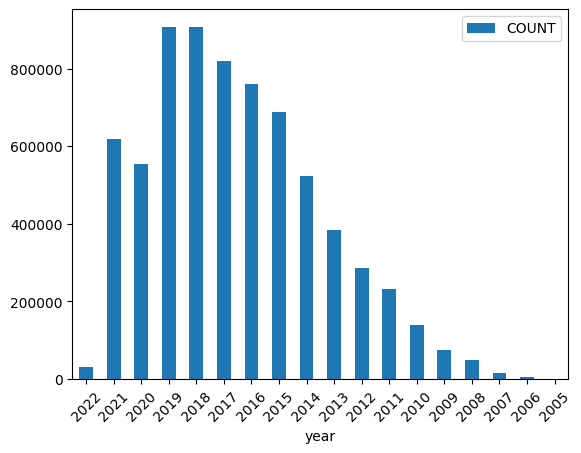

In [12]:
reviews_distribution_across_years.set_index("year").plot(kind="bar", rot=45)

In [15]:
business_restaurant_dir = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\yelp\\business_restaurante.parquet"
business_full_DS = spark.read.parquet(business_restaurant_dir)

In [16]:
business_full_DS.createOrReplaceTempView("business")

In [17]:
business_full_DS.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: long (nullable = true)
 |-- is_open: long (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking:

In [18]:
spark.catalog.listTables()

[Table(name='business', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='reviews', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [19]:
query_2 = """
SELECT count(name)
FROM business
"""
spark.sql(query_2).show()

+-----------+
|count(name)|
+-----------+
|      52268|
+-----------+



In [20]:
query_3 = """
SELECT *
FROM business
LIMIT 1
"""

spark.sql(query_3).show()

+--------------------+------------------+-----------+------------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+--------------------+--------------------+
|         business_id|              name|    address|        city|state|postal_code|  latitude|  longitude|stars|review_count|is_open|          attributes|          categories|               hours|
+--------------------+------------------+-----------+------------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+--------------------+--------------------+
|MTSW4McQd7CbVtyjq...|St Honore Pastries|935 Race St|Philadelphia|   CA|      19107|39.9555052|-75.1555641|  4.0|          80|      1|{null, null, u'no...|[Restaurants, Foo...|{7:0-21:0, 7:0-20...|
+--------------------+------------------+-----------+------------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+--------------------+--------------------+



In [21]:
query_4 = """
SELECT *
FROM reviews
LIMIT 5
"""

spark.sql(query_4).show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [22]:
query_5 = """
SELECT *
FROM reviews
WHERE YEAR(date) BETWEEN '2015' AND '2022'
"""

reviews_2015_2022 = spark.sql(query_5)

In [33]:
reviews_2015_2022.createOrReplaceTempView("reviews_2015_2022")

In [34]:
spark.catalog.listTables()

[Table(name='business', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='reviews', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='reviews_2015_2022', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [25]:
reviews_2015_2022_output_dir = "C:\\Users\\jdieg\\Desktop\\henry\\proyectos\\Google-Yelp\\.data\\yelp\\reviews_2015_2022.parquet"
reviews_2015_2022.write.parquet(reviews_2015_2022_output_dir)

Py4JJavaError: An error occurred while calling o88.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.jobAbortedError(QueryExecutionErrors.scala:651)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:288)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:186)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:560)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:116)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:860)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:390)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:363)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:793)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Ljava/lang/String;I)Z
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1218)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1423)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.parquet.hadoop.ParquetOutputCommitter.commitJob(ParquetOutputCommitter.java:48)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$26(FileFormatWriter.scala:277)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:642)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:277)
	... 42 more
